# CESM-LENS Model Evaluation
- It's always important to do some sort of model evaluation when working with a model. The issue with ocean BGC, and pCO2/CO2 Flux in particular, is the lack of strong observational data! We thought it best to validate the model with a few datasets that deal with the carbon system in general.
- Added on 7/19/17 a vertical velocity mean state

In [1]:
import glob

# Numerics 
import numpy as np
import pandas as pd
import xarray as xr

# Visualization
from mpl_toolkits.basemap import Basemap
import matplotlib.pyplot as plt
from matplotlib import gridspec
%matplotlib inline

# Constants

In [2]:
EBUS = ['CalCS', 'HumCS', 'CanCS', 'BenCS']

# Functions

In [3]:
def region_bounds(EBU):
    if EBU == "CalCS":
        lat1 = 25
        lat2 = 45
        lon1 = -135
        lon2 = -110
    elif EBU == 'HumCS':
        lat1 = -20
        lat2 = 0
        lon1 = -90
        lon2 = -70
    elif EBU == 'CanCS':
        lat1 = 10
        lat2 = 30
        lon1 = -25
        lon2 = -10
    elif EBU == 'BenCS':
        lat1 = -35
        lat2 = -14
        lon1 = 5
        lon2 = 20
    return lat1,lat2,lon1,lon2

In [4]:
def find_indices(latGrid, lonGrid, latPoint, lonPoint):
    dx = lonGrid - lonPoint
    dy = latGrid - latPoint
    reducedGrid = abs(dx) + abs(dy)
    min_ix = np.nanargmin(reducedGrid)
    i, j = np.unravel_index(min_ix, reducedGrid.shape)
    return i, j

# CESM-LENS Manipulation

In [5]:
lens_output, lens_lat, lens_lon = ( {} for i in range(3) )
for idx in EBUS:
    print('Operating on : {} ...').format(idx)
    fileDir = '/glade/p/work/rbrady/EBUS_BGC_Variability/FG_CO2/' + idx + '/'
    if idx == 'CalCS' or idx == 'HumCS' :
        ds_lens = xr.open_mfdataset(fileDir + '*.nc', concat_dim='ensemble')
    else:
        ds_lens = xr.open_mfdataset(fileDir + 'extended_domain/' + 'extended_domain*.nc', concat_dim='ensemble')
    # Fix quirk where TLAT/TLONG are coordinates which dissapear when you do ensemble mean.
    if idx == 'HumCS':
        ds_lens['TLAT'] = (('nlat', 'nlon'), ds_lens['TLAT'][0])
        ds_lens['TLONG'] = (('nlat', 'nlon'), ds_lens['TLONG'])
    else:
        ds_lens['TLAT'] = (('nlat', 'nlon'), ds_lens['TLAT'][0])
        ds_lens['TLONG'] = (('nlat', 'nlon'), ds_lens['TLONG'][0])
    ds_lens = ds_lens.mean(dim='ensemble')
    lat1,lat2,lon1,lon2 = region_bounds(idx)
    if idx != 'BenCS':
        lon1 = 360 + lon1; lon2 = 360 + lon2;
    a, c = find_indices(ds_lens['TLAT'].values, ds_lens['TLONG'].values,
                    lat1, lon1)
    b, d = find_indices(ds_lens['TLAT'].values, ds_lens['TLONG'].values,
                    lat2, lon2)
    ds_lens = ds_lens.isel(nlat=slice(a, b), nlon=slice(c,d))
    ds_lens = ds_lens.sel(time=slice('1982-01', '2011-12')).mean(dim='time')
    print 'Storing values in DataFrame...'
    lens_output[idx] = pd.DataFrame(ds_lens['FG_CO2'].values)
    lens_lat[idx] = pd.DataFrame(ds_lens['TLAT'].values)
    lens_lon[idx] = pd.DataFrame(ds_lens['TLONG'].values)
    del ds_lens

Operating on : CalCS ...
Storing values in DataFrame...


/glade/u/home/rbrady/.local/lib/python2.7/site-packages/dask/array/numpy_compat.py:45: RuntimeWarning: invalid value encountered in divide
  x = np.divide(x1, x2, out)


Operating on : HumCS ...
Storing values in DataFrame...
Operating on : CanCS ...
Storing values in DataFrame...
Operating on : BenCS ...
Storing values in DataFrame...


# Landschuetzer Data Manipulation

In [7]:
obs_output, obs_lat, obs_lon = ( {} for i in range(3) )
fileDir = '/glade/p/work/rbrady/Landschuetzer_pCO2/'
ds_obs = xr.open_dataset(fileDir + 'spco2_ETH_SOM-FFN_CDIAC_ETH30yr.nc', decode_times=False)
times = pd.date_range('1982-01', '2012-01', freq='M')
ds_obs['time'] = times
ds_obs.attrs = {}
X, Y = np.meshgrid(ds_obs['lon'].values, ds_obs['lat'].values)
ds_obs['LON'] = (('lat','lon'), X)
ds_obs['LAT'] = (('lat','lon'), Y)
ds_obs = ds_obs.mean(dim='time')
for idx in EBUS:
    print('Operating on : {} ...').format(idx)
    lat1,lat2,lon1,lon2 = region_bounds(idx)
    a, c = find_indices(ds_obs['LAT'].values, ds_obs['LON'].values,
                    lat1, lon1)
    b, d = find_indices(ds_obs['LAT'].values, ds_obs['LON'].values,
                    lat2, lon2)  
    ds_temp = ds_obs.isel(lat=slice(a,b), lon=slice(c,d))
    temp_data = ds_obs['fgco2_raw'].values
    mask = ( temp_data > 1e19 )
    temp_data[mask] = np.nan
    print 'Storing values in DataFrame...'
    obs_output[idx] = pd.DataFrame(ds_temp['fgco2_raw'].values)
    obs_lat[idx] = pd.DataFrame(ds_temp['LAT'].values)
    obs_lon[idx] = pd.DataFrame(ds_temp['LON'].values)
    del ds_temp                                    

Operating on : CalCS ...
Storing values in DataFrame...
Operating on : HumCS ...
Storing values in DataFrame...
Operating on : CanCS ...
Storing values in DataFrame...
Operating on : BenCS ...
Storing values in DataFrame...


# Vertical Velocity & Wind Stress

In [8]:
inDir ='/glade/p/work/rbrady/EBUS_BGC_Variability/global_fields/'
filename = 'WVEL-ensemble-landschuetzer-mean-global.nc'
ds = xr.open_dataset(inDir + filename)

In [9]:
wvel_output, wvel_lat, wvel_lon = ( {} for i in range(3) )
for idx in EBUS:
    print('Operating on : {} ...').format(idx)
    lat1,lat2,lon1,lon2 = region_bounds(idx)
    if idx != 'BenCS':
        lon1 = lon1+360
        lon2 = lon2+360
    a, c = find_indices(ds['TLAT'].values, ds['TLONG'].values, lat1, lon1)
    b, d = find_indices(ds['TLAT'].values, ds['TLONG'].values, lat2, lon2)
    ds_temp = ds.copy()
    ds_temp = ds_temp.isel(nlat=slice(a,b), nlon=slice(c,d))
    print 'Storing values in DataFrame...'
    # Convert to m/day
    wvel_output[idx] = pd.DataFrame(ds_temp['WVEL'].values * (60*60*24/100))
    wvel_lat[idx] = pd.DataFrame(ds_temp['TLAT'].values)
    wvel_lon[idx] = pd.DataFrame(ds_temp['TLONG'].values)

Operating on : CalCS ...
Storing values in DataFrame...
Operating on : HumCS ...
Storing values in DataFrame...
Operating on : CanCS ...
Storing values in DataFrame...
Operating on : BenCS ...
Storing values in DataFrame...


In [11]:
inDir ='/glade/p/work/rbrady/EBUS_BGC_Variability/global_fields/'
filename = 'TAUX-ensemble-landschuetzer-mean-global.nc'
ds = xr.open_dataset(inDir + filename)

In [12]:
taux_output, taux_lat, taux_lon = ( {} for i in range(3) )
for idx in EBUS:
    print('Operating on : {} ...').format(idx)
    lat1,lat2,lon1,lon2 = region_bounds(idx)
    if idx != 'BenCS':
        lon1 = lon1+360
        lon2 = lon2+360
    a, c = find_indices(ds['ULAT'].values, ds['ULONG'].values, lat1, lon1)
    b, d = find_indices(ds['ULAT'].values, ds['ULONG'].values, lat2, lon2)
    ds_temp = ds.copy()
    ds_temp = ds_temp.isel(nlat=slice(a,b), nlon=slice(c,d))
    print 'Storing values in DataFrame...'
    # Convert to m/day
    taux_output[idx] = pd.DataFrame(ds_temp['TAUX'].values * (60*60*24/100))
    taux_lat[idx] = pd.DataFrame(ds_temp['ULAT'].values)
    taux_lon[idx] = pd.DataFrame(ds_temp['ULONG'].values)

Operating on : CalCS ...
Storing values in DataFrame...
Operating on : HumCS ...
Storing values in DataFrame...
Operating on : CanCS ...
Storing values in DataFrame...
Operating on : BenCS ...
Storing values in DataFrame...


In [21]:
inDir ='/glade/p/work/rbrady/EBUS_BGC_Variability/global_fields/'
filename = 'TAUY-ensemble-landschuetzer-mean-global.nc'
ds = xr.open_dataset(inDir + filename)

In [22]:
tauy_output, tauy_lat, tauy_lon, angle = ( {} for i in range(4) )
for idx in EBUS:
    print('Operating on : {} ...').format(idx)
    lat1,lat2,lon1,lon2 = region_bounds(idx)
    if idx != 'BenCS':
        lon1 = lon1+360
        lon2 = lon2+360
    a, c = find_indices(ds['ULAT'].values, ds['ULONG'].values, lat1, lon1)
    b, d = find_indices(ds['ULAT'].values, ds['ULONG'].values, lat2, lon2)
    ds_temp = ds.copy()
    ds_temp = ds_temp.isel(nlat=slice(a,b), nlon=slice(c,d))
    print 'Storing values in DataFrame...'
    # Convert to m/day
    tauy_output[idx] = pd.DataFrame(ds_temp['TAUY'].values * (60*60*24/100))
    tauy_lat[idx] = pd.DataFrame(ds_temp['ULAT'].values)
    tauy_lon[idx] = pd.DataFrame(ds_temp['ULONG'].values)
    angle[idx] = pd.DataFrame(ds_temp['ANGLE'].values)

Operating on : CalCS ...
Storing values in DataFrame...
Operating on : HumCS ...
Storing values in DataFrame...
Operating on : CanCS ...
Storing values in DataFrame...
Operating on : BenCS ...
Storing values in DataFrame...


# Visual Comparison

In [112]:
def setup_map(ax, lat1, lat2, lon1, lon2):
    m = Basemap(projection='merc',
                lat_0=(lat1+lat2)/2,
                lon_0=(lon1+lon2)/2,
                #width=(2000*1000),
                #height=(2000*1000),
                llcrnrlon=lon1,
                urcrnrlon=lon2,
                llcrnrlat=lat1,
                urcrnrlat=lat2,
                fix_aspect=False,
                resolution='c')
    m.drawcoastlines(color='#D3D3D3')
    #m.drawcountries()
    #m.drawstates()
    m.fillcontinents(color='#D3D3D3')
    m.drawmapboundary(fill_color='white')
    m.drawparallels(np.arange(lat1, lat2+1, 3),
                   labels=[False,True,False,False], size=20,
                   color='w')
    m.drawmeridians(np.arange(lon1, lon2+1, 2),
                   labels=[False, False, False, False], size=20,
                   color='w')
    return m

In [16]:
def visual_bounds(EBU):
    if EBU == "CalCS":
        lat1 = 25
        lat2 = 43
        lon1 = -133
        lon2 = -110
    elif EBU == 'HumCS':
        lat1 = -20
        lat2 = -2
        lon1 = -90
        lon2 = -70
    elif EBU == 'CanCS':
        lat1 = 10
        lat2 = 28
        lon1 = -25
        lon2 = -10
    elif EBU == 'BenCS':
        lat1 = -35
        lat2 = -15
        lon1 = 5
        lon2 = 20
    return lat1,lat2,lon1,lon2

In [113]:
def map_upwelling_clim(ax, EBU, typ):
    if typ == 'obs':
        lon = obs_lon[EBU].values
        lat = obs_lat[EBU].values
        data = obs_output[EBU].values
        data = np.ma.array(data, mask=np.isnan(data))
    elif typ == 'model':
        lon = lens_lon[EBU].values
        lat = lens_lat[EBU].values
        data = lens_output[EBU].values
        data = np.ma.array(data, mask=np.isnan(data))
    lat1,lat2,lon1,lon2 = visual_bounds(EBU)
    if typ == 'model' and EBU != 'BenCS':
        lon1 = 360 + lon1; lon2 = 360 + lon2;
    m = setup_map(ax, lat1, lat2, lon1, lon2)
    m.contourf(lon, lat, data, np.linspace(-2.5, 2.5, num=21, endpoint=True),
               latlon=True, cmap="RdBu_r", extend="both")
    return m

In [50]:
def map_vertical_velocity(ax, EBU):
    lon = wvel_lon[EBU].values
    lat = wvel_lat[EBU].values
    data = wvel_output[EBU].values
    data = np.ma.array(data, mask=np.isnan(data))
    lat1,lat2,lon1,lon2 = visual_bounds(EBU)
    if EBU != 'BenCS':
        lon1 = 360 + lon1; lon2 = 360 + lon2;
    m = setup_map(ax, lat1, lat2, lon1, lon2)
    m.pcolor(lon, lat, data, vmin=-1, vmax=1, latlon=True, cmap='BrBG_r',
            edgecolor='#D3D3D3')
    #m.colorbar(location='bottom', extend='both')
    return m

In [97]:
def map_vector_winds(ax, EBU, num=2):
    lon = taux_lon[EBU].values
    lat = taux_lat[EBU].values
    u = taux_output[EBU].values
    u = np.ma.array(u, mask=np.isnan(u))
    v = tauy_output[EBU].values
    v = np.ma.array(v, mask=np.isnan(v))
    # Rotate winds
    rot = angle[EBU].values
    uNew = u*np.cos(rot) - v*np.sin(rot) 
    vNew = u*np.sin(rot) + v*np.cos(rot) 
    # Visual Stuff
    lat1,lat2,lon1,lon2 = visual_bounds(EBU)
    if EBU != 'BenCS':
        lon1 = 360 + lon1; lon2 = 360 + lon2;
    m = setup_map(ax, lat1, lat2, lon1, lon2)
    Q = m.quiver(lon[::num,::num], lat[::num,::num], uNew[::num,::num], vNew[::num,::num], 
                 latlon=True, pivot='mid', scale_units='inches')
    return m

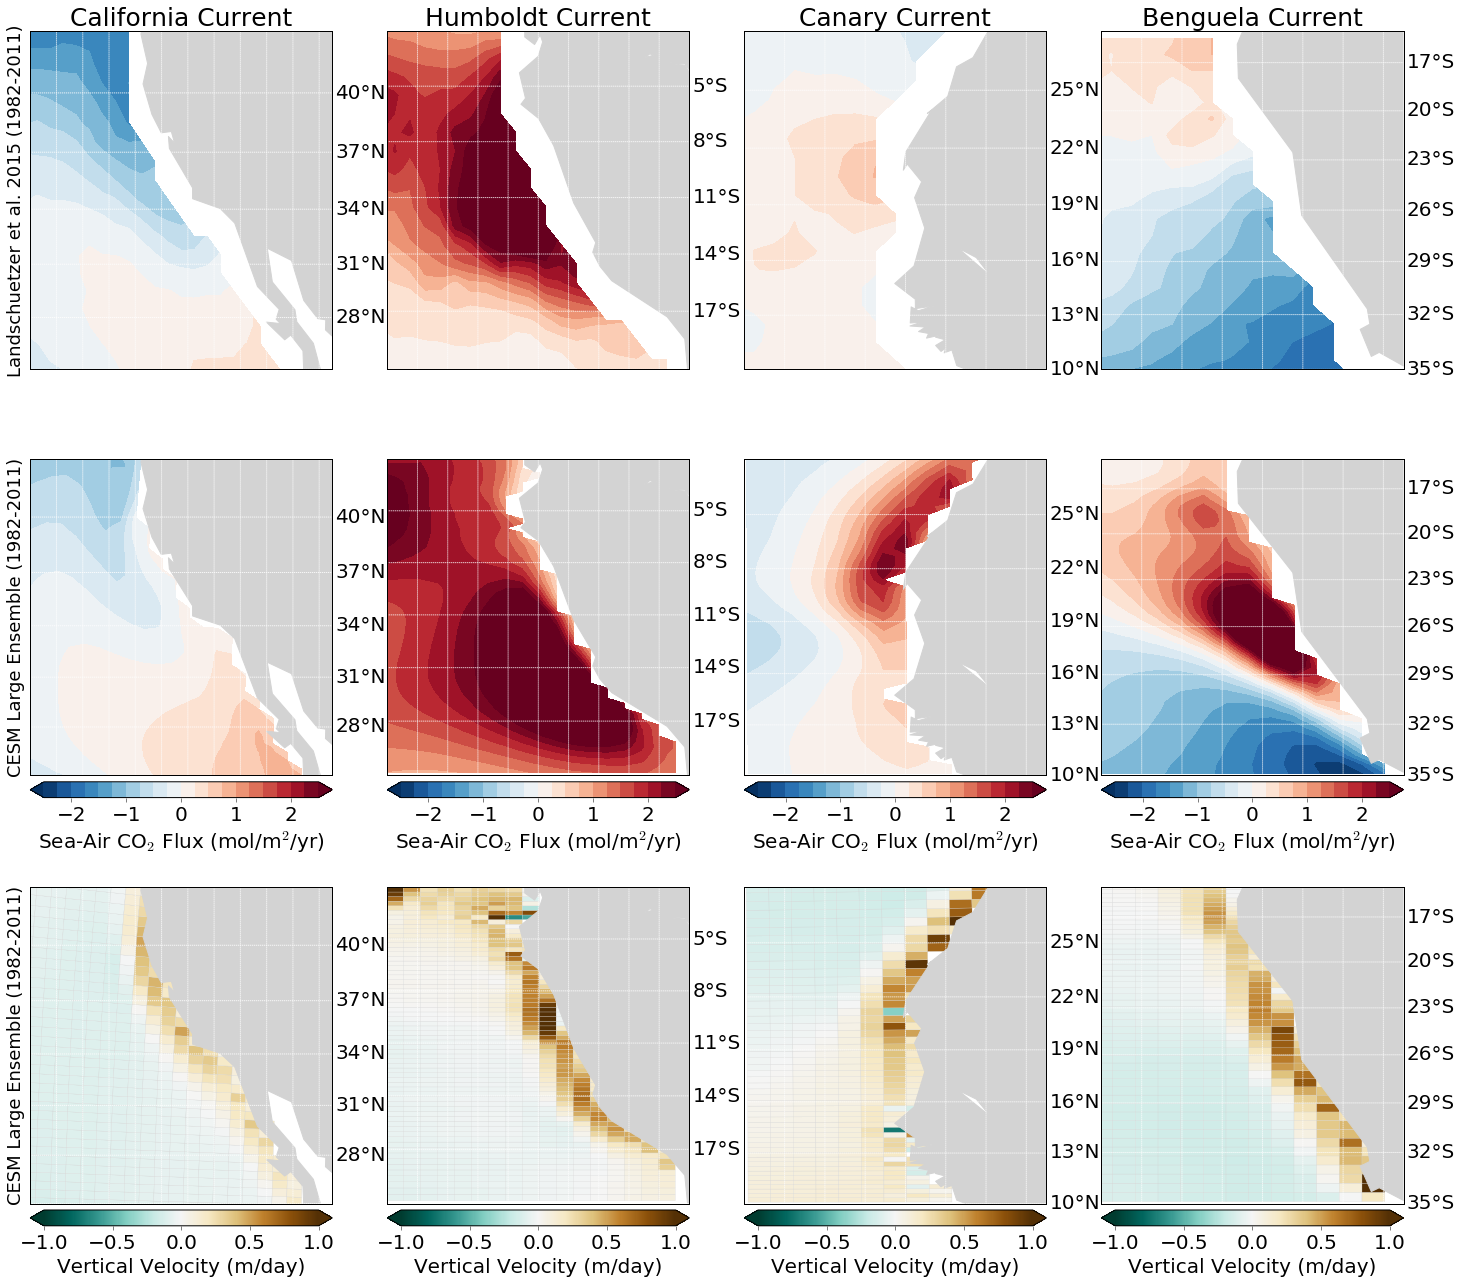

In [116]:
names = ['California Current',
         'Humboldt Current',
         'Canary Current',
         'Benguela Current']
fig = plt.figure(figsize=(20,18))
counter_top = 1
counter_mid = 5
counter_bottom = 9
for idx in EBUS:
    # Landscheutzer Climatology (Top)
    ax = fig.add_subplot(3, 4, counter_top)
    m = map_upwelling_clim(ax, idx, 'obs')
    if counter_top == 1:
        plt.ylabel('Landschuetzer et al. 2015 (1982-2011)', size=18)    
    plt.title(names[counter_top-1], size=25)
    counter_top += 1
    # CESM-LENS Climatology (Middle)
    ax = fig.add_subplot(3, 4, counter_mid)
    m = map_upwelling_clim(ax, idx, 'model')
    if counter_mid == 5:
        plt.ylabel('CESM Large Ensemble (1982-2011)', size=18)   
    cbar = m.colorbar(location="bottom")
    cbar.set_ticks(np.arange(-2, 2.1, 1))
    cbar.ax.tick_params(labelsize=20, direction='out') 
    cbar.set_label('Sea-Air CO$_{2}$ Flux (mol/m$^{2}$/yr)', size=20)
    counter_mid +=1
    # Mean State Upwelling (Bottom)
    ax = fig.add_subplot(3, 4, counter_bottom)
    m = map_vertical_velocity(ax, idx)
    if counter_bottom == 9:
        plt.ylabel('CESM Large Ensemble (1982-2011)', size=18)
    #Q = map_vector_winds(ax, idx)
    cbar = m.colorbar(location='bottom', extend='both')
    cbar.set_ticks(np.arange(-1, 1.1, 0.5))
    cbar.ax.tick_params(labelsize=20, direction='out') 
    cbar.set_label('Vertical Velocity (m/day)', size=20)
    counter_bottom += 1
fig.tight_layout()
plt.savefig('landschuetzer-model-climatological-comparison-withUpwelling.png', pad_inches=3)